This file does the following:
Implement an ARIMA(1,1,2) model on daily volatility of NIKE and use residuals as volatility shocks (uncertainty).
Implement SVR and LASSO on features of news articles of NIKE to predict volatility shocks.


# Import modules and news files

In [1]:
import re
import glob
import nltk
import pandas as pd
import numpy as np
from geotext import GeoText
import math
import matplotlib

## Import news files

In [3]:
file_names = glob.glob("./NewsData/Output-NKE*")

In [4]:
file_names[:5]

['./NewsData/Output-NKE-1-20010329-1612.txt',
 './NewsData/Output-NKE-1-20010629-NA.txt',
 './NewsData/Output-NKE-1-20010928-435.txt',
 './NewsData/Output-NKE-1-20011224-NA.txt',
 './NewsData/Output-NKE-1-20020328-2412.txt']

Split the text file into titles and contexts.

In [7]:
pattern = re.compile(".+\d+\swords")
titles = []
dates = []
texts = []
num_words = []
times = []
for i in range(0,len(file_names)):
    file_i = file_names[i]
    ff = file_i.split('.')
    ff = ff[-2].split('-')
    dates.append(ff[-2])
    times.append(ff[-1])
    find_title = False
    with open(file_i) as f:
        r = f.read()
        paras = r.split("\n")
        paras = paras[0:-1-(len(paras[-1])<10)]
        j = 0
        while j<=len(paras)-1:
            p = paras[j]
            if pattern.match(p):
                m = re.split(r"\swords",p)
                num_words.append(int(m[0].split(" ")[-1]))
                titles.append(" ".join(paras[0:j]))
                text = " ".join(paras[j+1:])
                texts.append(text)
                find_title = True
                break
            j +=1
        if not find_title:
            titles.append("")
            num_words.append(None)
            texts.append(" ".join(paras))

In [9]:
len(times)

7540

## Import NKE return and volatility file

In [12]:
NKE_PRC = pd.read_csv("NKE_daily.csv")
NKE_vol = pd.read_csv("NKE_vol.csv",names=["date","volatility","volume"])

In [13]:
del NKE_PRC['PERMNO']
NKE_PRC['ret'] =100*np.log(NKE_PRC['prc']).diff().shift(-1)

In [14]:
nke_trading = pd.merge(NKE_PRC, NKE_vol, how='inner', on='date')

In [15]:
nke_trading.date[0:4]

0    20010410
1    20010411
2    20010412
3    20010416
Name: date, dtype: int64

## Combine NKE volatility with news
If a certain piece of news occur between 16:00 and 9:30 the next day, it is classified as the next day's news

In [16]:
import datetime
dates0 = [datetime.date(int(dates[i][0:4]),int(dates[i][4:6]),int(dates[i][6:8])) for i in range(0,len(dates))]
one_day = datetime.timedelta(days=1)
dates_e = [dates0[i] + one_day if (times[i] != 'NA' and int(times[i]) > 1600) else dates0[i] for i in range(0,len(dates0))]

In [17]:
times = [None if (times[i] == 'NA' or int(times[i]) >2400) else int(times[i]) for i in range(0,len(times))]

In [18]:
hours = [None if times[i] == None else math.floor(times[i]/100) for i in range(0,len(times))]

In [19]:
dates_t = [str(nke_trading.date[i]) for i in range(0,len(nke_trading))]

In [20]:
dates_t = [datetime.date(int(dates_t[i][0:4]),int(dates_t[i][4:6]),int(dates_t[i][6:8])) for i in range(0,len(dates_t))]

In [21]:
news = pd.DataFrame({'index':list(range(0,len(dates))),'date':dates,'date_e':dates_e,'hour':hours,'time':times,'title':titles,'num_w':num_words,'file_name':file_names})

In [22]:
news.head()

,date,date_e,file_name,hour,index,num_w,time,title
0,20010329,2001-03-30,./NewsData/Output-NKE-1-20010329-1612.txt,16.0,0,230.0,1612.0,Timberland warns cattle diseases could hurt bu...
1,20010629,2001-06-29,./NewsData/Output-NKE-1-20010629-NA.txt,NaN,1,177.0,NaN,Business Brief -- Nike Inc.: Profit Climbs 30%...
2,20010928,2001-09-28,./NewsData/Output-NKE-1-20010928-435.txt,4.0,2,279.0,435.0,Adidas CEO sees no reason for profit warning-p...
3,20011224,2001-12-24,./NewsData/Output-NKE-1-20011224-NA.txt,NaN,3,1278.0,NaN,Abreast of the Market Wary Investors Resist St...
4,20020328,2002-03-29,./NewsData/Output-NKE-1-20020328-2412.txt,NaN,4,212.0,NaN,"Philips/No Charges -2: ""No Lasting Asset Value..."


date_e means effective date

In [23]:
news = news.sort_values(by=['date_e', 'time'], ascending=[1, 1]).reset_index(drop=True)

In [431]:
news.head(5)

,date,date_e,file_name,hour,index,num_w,time,title,date_t
0,20010102,2001-01-02,./NewsData/Output-NKE-192-20010102-610.txt,6.0,2743,162.0,610.0,French court fines Adidas 2.4 mln euros.,None
1,20010102,2001-01-02,./NewsData/Output-NKE-191-20010102-1144.txt,11.0,2734,201.0,1144.0,UPDATE 1-Adidas paid French fine of 2.4 mln eu...,None
2,20010103,2001-01-03,./NewsData/Output-NKE-190-20010103-1310.txt,13.0,2725,133.0,1310.0,"Nike Pres Clarke Registers 140,000 More Common...",None
3,20010103,2001-01-04,./NewsData/Output-NKE-188-20010103-1717.txt,17.0,2651,183.0,1717.0,UPDATE 1-Nike exec Clarke files to sell $7.8 m...,None
4,20010103,2001-01-04,./NewsData/Output-NKE-186-20010103-1941.txt,19.0,2633,208.0,1941.0,UPDATE 2-Nike exec Clarke files to sell $7.8 m...,None


If date_e happens between (date_{t-1}, date_t], then it is combined with date_t

In [25]:
i = 0
j = 1
dates_i = news['date_e']
index = [None]*len(dates_i)
while i <= len(index)-1:
    if dates_i[i] > dates_t[j-1]:
        while j<= len(dates_t)-1 and dates_i[i] > dates_t[j]:
            j +=1
        index[i] = j
    i += 1
            

In [26]:
date_new = [dates_t[i] if i != None else None for i in index]

In [27]:
news['date_t'] = date_new

In [28]:
news.head()

,date,date_e,file_name,hour,index,num_w,time,title,date_t
0,20010102,2001-01-02,./NewsData/Output-NKE-192-20010102-610.txt,6.0,2743,162.0,610.0,French court fines Adidas 2.4 mln euros.,None
1,20010102,2001-01-02,./NewsData/Output-NKE-191-20010102-1144.txt,11.0,2734,201.0,1144.0,UPDATE 1-Adidas paid French fine of 2.4 mln eu...,None
2,20010103,2001-01-03,./NewsData/Output-NKE-190-20010103-1310.txt,13.0,2725,133.0,1310.0,"Nike Pres Clarke Registers 140,000 More Common...",None
3,20010103,2001-01-04,./NewsData/Output-NKE-188-20010103-1717.txt,17.0,2651,183.0,1717.0,UPDATE 1-Nike exec Clarke files to sell $7.8 m...,None
4,20010103,2001-01-04,./NewsData/Output-NKE-186-20010103-1941.txt,19.0,2633,208.0,1941.0,UPDATE 2-Nike exec Clarke files to sell $7.8 m...,None


# Visualize data and preliminary analysis

In [29]:
trading = DataFrame(nke_trading)
trading['date'] = dates_t
trading.head()

,date,prc,ret,volatility,volume
0,2001-04-10,39.42,-3.537222,36.772456,14.4120
1,2001-04-11,38.05,-1.562739,34.221051,9.7568
2,2001-04-12,37.46,-1.370805,40.949948,13.4616
3,2001-04-16,36.95,0.674311,45.774443,13.4528
4,2001-04-17,37.20,2.757333,40.809388,7.9200


## Fit an ARIMA model to the volatility to get volatility shocks

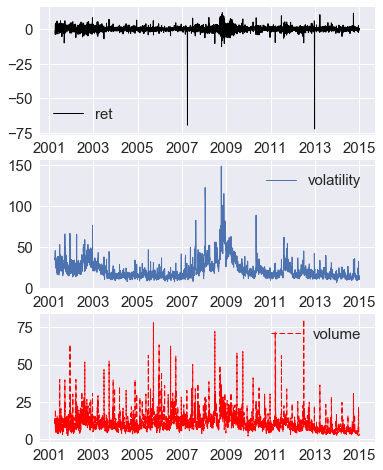

In [30]:
fig, axes = plt.subplots(3,1,figsize = (6,8))
axes[0].plot(trading['date'], trading['ret'],'k',linewidth = 1)
axes[0].legend()
axes[1].plot(trading['date'], trading['volatility'],linewidth = 1)
axes[1].legend()
axes[2].plot(trading['date'], trading['volume'],'r--',linewidth = 1)
axes[2].legend()

To retrieve volatility shock, we fit an ARIMA model to volatility, since theoretically this is a slow decaying process, which is supported by the empirical evidences as below.

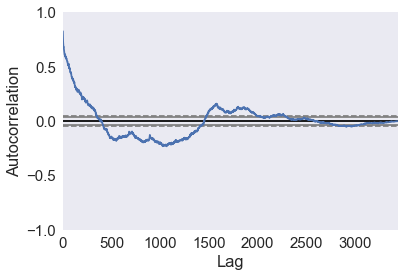

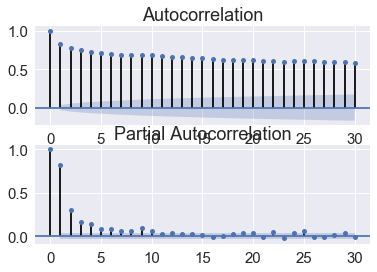

In [31]:
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def plotcor(series):
    autocorrelation_plot(series)
    pyplot.figure()
    pyplot.subplot(211)
    plot_acf(series, ax=pyplot.gca(), lags=30)
    pyplot.subplot(212)
    plot_pacf(series, ax=pyplot.gca(),lags = 30)
    pyplot.show()
plotcor(trading['volatility'])


This plot is more supportive of an ARIMA(p,1,q) model due to extremely low decay

In [442]:
series = np.array(trading['volatility'])
arimas = DataFrame(np.zeros((50,8)),columns = ['p','d','q','AIC','BIC','HQIC','ADF_p','Suc'])
row = 0
for d in range(0,2):
    for i in range(0,5):
        for j in range(0,5):
            #print("Start fitting model for ARIMA(%d,%d,%d)" % (i, d, j))
            arimas['p'][row] = i
            arimas['q'][row] = j        
            arimas['d'][row] = d
            try:
                model = ARIMA(series,order = (i,d,j))
                model_fit = model.fit(disp = 0)
                arimas['AIC'][row] = model_fit.aic
                arimas['BIC'][row] = model_fit.bic
                arimas['HQIC'][row] = model_fit.hqic
                residuals = model_fit.resid
                dftest = adfuller(residuals)
                arimas['ADF_p'][row] = dftest[1]
                arimas['Suc'][row] = True
            except:
                arimas['Suc'][row] = False
            row +=1

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [447]:
arimas2 = arimas.loc[arimas['Suc']==1,:]
arimas_sorted = arimas2.sort_values(by=['BIC'],ascending = True).reset_index(drop=True)
arimas_sorted.head(5)

,p,d,q,AIC,BIC,HQIC,ADF_p,Suc
0,1.0,1.0,2.0,22127.880103,22158.590419,22138.850539,0.000000e+00,1.0
1,2.0,1.0,1.0,22132.119611,22162.829928,22143.090047,5.632186e-24,1.0
2,2.0,1.0,2.0,22127.602225,22164.454605,22140.766748,0.000000e+00,1.0
3,2.0,0.0,2.0,22128.075722,22164.929847,22141.240674,0.000000e+00,1.0
4,1.0,1.0,3.0,22128.516276,22165.368655,22141.680799,0.000000e+00,1.0


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3436
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -11058.940
Method:                       css-mle   S.D. of innovations              6.047
Date:                Sun, 03 Sep 2017   AIC                          22127.880
Time:                        17:28:19   BIC                          22158.590
Sample:                             1   HQIC                         22138.851
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.017     -0.314      0.753      -0.038       0.027
ar.L1.D.y      0.6763      0.047     14.248      0.000       0.583       0.769
ma.L1.D.y     -1.2242      0.055    -22.370      0.0

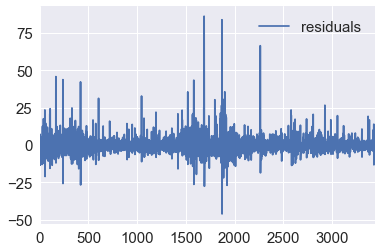

         residuals
count  3436.000000
mean     -0.005243
std       6.047941
min     -46.065357
25%      -2.838386
50%      -0.496910
75%       2.070967
max      86.268516
Results of Dickey-Fuller Test:
Test Statistic                  -58.408050
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3435.000000
Critical Value (5%)              -2.862382
Critical Value (1%)              -3.432255
Critical Value (10%)             -2.567218
dtype: float64


In [448]:
# fit model
from statsmodels.tsa.stattools import adfuller
model = ARIMA(series,order = (1,1,2))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame({'residuals':model_fit.resid})
residuals.plot()
pyplot.show()
print(residuals.describe())
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
test_stationarity(residuals)

### Check the independence of residuals

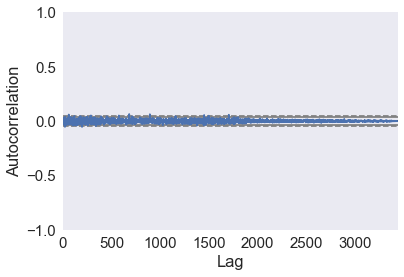

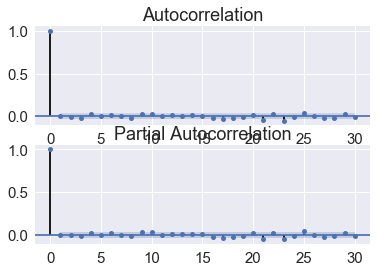

In [35]:

plotcor(residuals)
#plotcor(residuals.ioc[:0].values)

In [466]:
# Ljung-Box test
from statsmodels.stats import diagnostic as diag
ljungbox = diag.acorr_ljungbox(residuals, lags=20, boxpierce=False)
ljungbox_p = DataFrame({'lag': list(range(1,21)), 'p value': ljungbox[1]})
ljungbox_p

,lag,p value
0,1,0.853679
1,2,0.890605
2,3,0.696815
3,4,0.516502
4,5,0.661123
5,6,0.652054
6,7,0.756121
7,8,0.742085
8,9,0.520926
9,10,0.354082


This looks much better. We define the residuals as shocks which are triggered by the news. They can be treated as independent.

In [36]:
shocks = residuals
shocks['shocks'] = residuals['residuals']
shocks['dates'] = dates_t[len(dates_t)-len(residuals):len(dates_t)]
del shocks['residuals']
shocks.head()

,shocks,dates
0,-2.546194,2001-04-11
1,5.796262,2001-04-12
2,7.296761,2001-04-16
3,-1.253071,2001-04-17
4,-3.027248,2001-04-18


In [37]:
news_in = news.loc[ news['date_t'].notnull()].reset_index(drop=True)

### Compare the shocks on days with and without news

In [38]:
# dates that have news
dates_news = news_in['date_t'].unique()
df = DataFrame({'dates': dates_news, 'has_news': np.ones((len(dates_news)))})
shocks1 = pd.merge(shocks,df,on = 'dates', how = 'left')
shocks1.has_news.loc[shocks1.has_news.isnull()]=0
shocks1.head()

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,shocks,dates,has_news
0,-2.546194,2001-04-11,0.0
1,5.796262,2001-04-12,0.0
2,7.296761,2001-04-16,1.0
3,-1.253071,2001-04-17,1.0
4,-3.027248,2001-04-18,0.0


In [39]:
import seaborn as sns

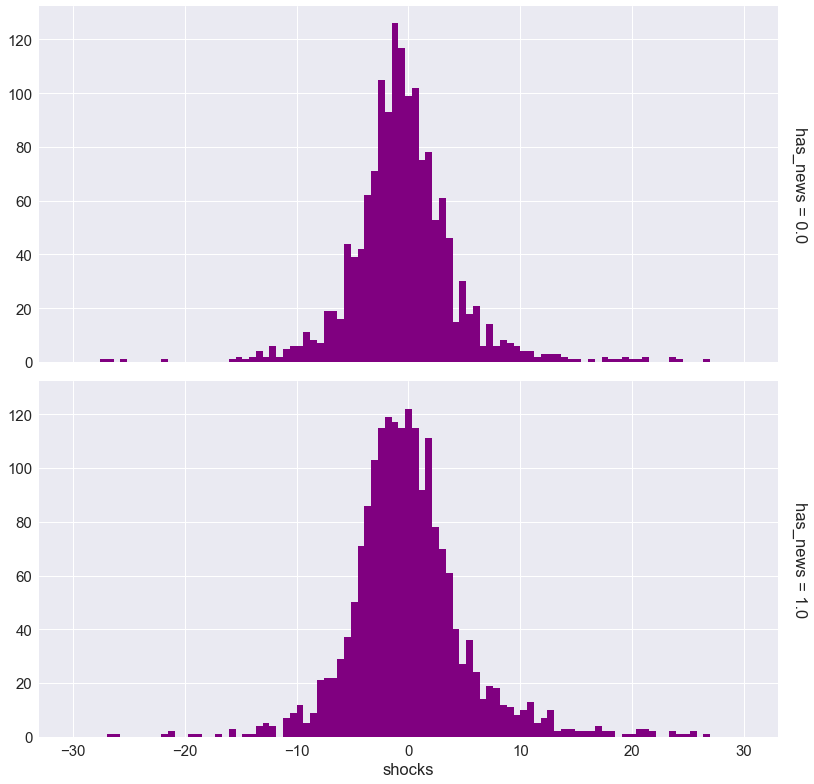

In [40]:
g = sns.FacetGrid(shocks1, row="has_news", margin_titles=True,aspect=2, size=5.5)
#g.map(plt.hist, "shocks",color="purple",bins = np.linspace(np.min(shocks1.shocks),np.max(shocks1.shocks),40))
g.map(plt.hist, "shocks",color="purple",bins = np.linspace(-30,30,100))

In [41]:
#g = sns.FacetGrid(shocks1, row="has_news", margin_titles=True,aspect=2, size=5.5)
#g.map(sns.kdeplot, "shocks")
#pyplot.show()

In [42]:
# Two sample t test of absolute value of shocks
from scipy.stats import ttest_ind

shocks_news = shocks1[shocks1['has_news']==1]
shocks_nonews = shocks1[shocks1['has_news']==0]

ttest_ind(shocks_news['shocks'], shocks_nonews['shocks'])

Ttest_indResult(statistic=2.3672446197445596, pvalue=0.017976225177338604)

The t test shows that days with news see larger volatility shocks.

In [43]:
shocks_news.describe()

,shocks,has_news
count,1927.000000,1927.0
mean,0.210749,1.0
std,6.063082,0.0
min,-26.646904,1.0
25%,-2.878196,1.0
50%,-0.366383,1.0
75%,2.336490,1.0
max,66.534939,1.0


In [44]:
shocks_nonews.describe()

,shocks,has_news
count,1509.000000,1509.0
mean,-0.281065,0.0
std,6.019294,0.0
min,-46.065357,0.0
25%,-2.737868,0.0
50%,-0.653117,0.0
75%,1.774939,0.0
max,86.268516,0.0


We notice several extremely large values. We may want to sort shocks to have a look at them

In [45]:
shocks2 = shocks1.sort_values(by=['shocks'], ascending=[1]).reset_index(drop=True)

In [46]:
shocks2.head(10)

,shocks,dates,has_news
0,-46.065357,2008-10-13,0.0
1,-27.528571,2008-01-24,0.0
2,-26.899158,2008-12-24,0.0
3,-26.646904,2002-12-23,1.0
4,-26.274344,2007-08-20,1.0
5,-25.704364,2002-04-04,0.0
6,-21.906579,2008-12-26,1.0
7,-21.906317,2008-11-03,0.0
8,-20.992528,2001-06-29,1.0
9,-20.950578,2008-12-22,1.0


# Parse texts to extract words, cities and countries.

In [299]:
import collections
import glob
import nltk, re, pprint
def dicUpdate(dic,key,item):
    if key in dic.keys():
        dic[key].append(item)
    else:
        dic[key]=[item]
    return dic
def parseText(text,text_index,stemmer,cities,countries,pattern):
    words_dic = {}
    nums = 0
    geo = GeoText(text)
    if geo.cities:
        for city in geo.cities:
            cities = dicUpdate(cities, city, text_index)
    if geo.countries:
        for country in geo.countries:
            countries = dicUpdate(countries, country, text_index)
    tokens = nltk.word_tokenize(text.decode('utf-8'))
    for word in tokens:        
        word_s = stemmer.stem(word).lower()
        if pattern.match(word_s):
            nums +=1
            continue
        if word_s in words_dic:
            words_dic[word_s] +=1
        else:
            words_dic[word_s] = 1
    return (words_dic,cities,countries,nums)




In [348]:
stemmer = nltk.PorterStemmer()
cities = {}
countries = {}
words_dic_list = []
nums = []
for i in range(0,len(texts)):
    if i % 50 ==0:
        print("Processing the %d'th file.\n" % i)
    text = texts[i] + " " + titles[i]
    pattern = re.compile(".*\d+.*")
    (words_dic,cities,countries,num) = parseText(text,i,stemmer,cities,countries,pattern)
    words_dic_list.append(words_dic)
    nums.append(num)

Processing the 0'th file.

Processing the 50'th file.

Processing the 100'th file.

Processing the 150'th file.

Processing the 200'th file.

Processing the 250'th file.

Processing the 300'th file.

Processing the 350'th file.

Processing the 400'th file.

Processing the 450'th file.

Processing the 500'th file.

Processing the 550'th file.

Processing the 600'th file.

Processing the 650'th file.

Processing the 700'th file.

Processing the 750'th file.

Processing the 800'th file.

Processing the 850'th file.

Processing the 900'th file.

Processing the 950'th file.

Processing the 1000'th file.

Processing the 1050'th file.

Processing the 1100'th file.

Processing the 1150'th file.

Processing the 1200'th file.

Processing the 1250'th file.

Processing the 1300'th file.

Processing the 1350'th file.

Processing the 1400'th file.

Processing the 1450'th file.

Processing the 1500'th file.

Processing the 1550'th file.

Processing the 1600'th file.

Processing the 1650'th file.

Pro

In [50]:
# first use date_t to combine all dictionaries and rank by date_t
words_dic_byday = {}
for i in range(0,len(news_in)):
    date = news_in['date_t'][i]
    index = news_in['index'][i]
    if date not in words_dic_byday:
        words_dic_byday[date] = words_dic_list[index]
    else:
        words_dic_byday[date].update(words_dic_list[index])

In [51]:
# Combine all dictionaries
words_all = {}
for d in words_dic_byday.keys():
    dic_day = words_dic_byday[d]
    for key in dic_day:
        if key in words_all:
            words_all[key] += dic_day[key]
        else:
            words_all[key] = dic_day[key]
# Construct (word, frequency) tuple
words_list = []
for key in words_all.keys():
    words_list.append((key,words_all[key]))
# rank by frequency


In [52]:
words_list_only = [words_list[i][0] for i in range(0,len(words_list))]
word_tags = nltk.pos_tag(words_list_only)

We delete words that does not have much meaning, such as "the", "at", etc. We use the tags to classify words.

In [53]:
tag_in = {}
#nltk.help.upenn_tagset()
tag_interest = ['CD', 'DT','FW','JJ','JJR','JJS','LS','MD','NN','NNP','NNS','PDT','RB','RBR','RBS','UH','VB','VBD','VBG','VBN','VBP','VBZ']
tags = [word_tag[1] for word_tag in word_tags]
tags_uniq = set(tags)
for tag in tags_uniq:
    tag_in[tag] = (tag in tag_interest)


In [54]:
words_list_dic = {}
for i in range(0,len(words_list)):
    words_list_dic[words_list[i][0]] = words_list[i][1]
words_list_interest = []
words_list_interest_count = []
for (word,tag) in word_tags:
    if tag_in[tag]:
        words_list_interest.append((word, words_list_dic[word]))
        

In [55]:
words_freq = [x[1] for x in words_list_interest]
counter=collections.Counter(words_freq)
words_freq_mat = np.zeros((len(counter),2))
i = 0
for key in counter.keys():
    words_freq_mat[i][0] = key
    words_freq_mat[i][1] = counter[key]
    i +=1

In [56]:
df_word_freq = DataFrame(words_freq_mat,columns = ['frequency','count'])
df_word_freq = df_word_freq.sort_values(by=['frequency'], ascending=[1]).reset_index(drop=True)
df_word_freq.head()
df_word_freq.tail()

,frequency,count
912,6542.0,1.0
913,6729.0,1.0
914,9003.0,1.0
915,20085.0,1.0
916,46656.0,1.0


In [57]:
len(words_list)

50614

In [58]:
# This is too sparse, se for words that only appear one to four times, we do not treat them as features. 
words_all2 = {};
for key in words_list_interest:
    if key[1] > 100 and key[1] < 5000:
        words_all2[key[0]] = key[1]
len(words_all2)


2174

Start constructing featers

In [59]:
words_index = {}
i = 0
word_location = [None]*len(words_all2)
for key in words_all2:
    words_index[key] = i
    word_location[i] = key
    i +=1
for key in words_all:
    if key not in words_index:
        words_index[key] = -1

In [60]:
X = np.zeros((len(words_dic_byday),len(words_all2)))
for i in range(0, len(words_dic_byday)):
    date = news_in['date_t'][i]
    dic_day = words_dic_byday[date]
    for key in dic_day:
        pos =  words_index[key] 
        if pos != -1:
            X[i][pos] = dic_day[key]
    

In [61]:
np.shape(X)

(1927, 2174)

In [62]:
Y = shocks2['shocks'].loc[shocks2['has_news']==1]
np.shape(Y.values.reshape(len(Y),1))

(1927, 1)

In [63]:
Y_d = DataFrame({"shocks":Y}).reset_index(drop=True)

In [64]:
#np.concatenate((X,Y.values.reshape(len(Y),1)), axis = 1)
words = DataFrame(X, columns = word_location)
words['shocks']=Y_d['shocks']
words = words.loc[words['shocks'].notnull()].reset_index(drop=True)
len(words)

1927

### Split to training and test sets.

In [65]:
# to make this notebook's output identical at every run
np.random.seed(42)
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [160]:
train_set, test_set = split_train_test(words, 0.2)
print(len(train_set), "train +", len(test_set), "test")

(1542, 'train +', 385, 'test')


In [67]:
test_set.head()

,convers,four,protest,asian,upsid,climb,accus,aug,edward,buyer,...,appoint,experienc,samsung,rule,portion,emerg,partli,decemb,frankfurt,shocks
1448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.367264
1651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.355020
1862,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,12.012233
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.473173
331,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-3.892068


In [161]:
X_train = train_set.ix[:,0:-1]
Y_train = train_set.ix[:,-1]

In [153]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

X_prepared = num_pipeline.fit_transform(X_train)
np.shape(X_prepared)

(1542, 2174)

### SVR with grid search 

In [70]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svm_reg = SVR(kernel="rbf")
svm_reg.fit(X_prepared, Y_train)
Y_predictions = svm_reg.predict(X_prepared)
svm_mse = mean_squared_error(Y_train, Y_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

4.0317550210867443

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X_prepared, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=10.0 ...........................................
[CV] ............................ kernel=linear, C=10.0, total=   3.0s
[CV] ............................ kernel=linear, C=10.0, total=   2.9s
[CV] ............................ kernel=linear, C=10.0, total=   3.0s
[CV] ............................ kernel=linear, C=10.0, total=   3.0s
[CV] kernel=linear, C=10.0 ...........................................
[CV] kernel=linear, C=30.0 ...........................................
[CV] kernel=linear, C=30.0 ...........................................
[CV] kernel=linear, C=30.0 ...........................................
[CV] ............................ kernel=linear, C=30.0, total=   2.9s
[CV] kernel=lin

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.0s


[CV] ......................... kernel=linear, C=10000.0, total=   2.9s
[CV] ......................... kernel=linear, C=10000.0, total=   2.9s
[CV] ......................... kernel=linear, C=30000.0, total=   2.9s
[CV] kernel=linear, C=30000.0 ........................................
[CV] kernel=linear, C=30000.0 ........................................
[CV] kernel=linear, C=30000.0 ........................................
[CV] ......................... kernel=linear, C=30000.0, total=   2.8s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] ......................... kernel=linear, C=30000.0, total=   2.8s
[CV] ......................... kernel=linear, C=30000.0, total=   2.8s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] ......................... kernel=linear, C=30000.0, total=   2.8s
[CV] kernel=rbf, C=1.0, gamma=0.01 ...................................
[CV] .

[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=   3.4s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=   3.2s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=   3.3s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=1.0, total=   3.2s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=   3.2s
[CV] kernel=rbf, C=3.0, gamma=3.0 ....................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=   3.2s
[CV] kernel=rbf, C=10.0, gamma=0.01 ..................................
[CV] ..................... kernel=rbf, C=3.0, gamma=3.0, total=   3.3s
[CV] kernel=rbf, C=10.0, gamma=0.01 ..................................
[CV] .

[CV] .................... kernel=rbf, C=30.0, gamma=0.3, total=   2.8s
[CV] kernel=rbf, C=30.0, gamma=1.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=   2.8s
[CV] kernel=rbf, C=30.0, gamma=1.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=   2.7s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=   2.7s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=   2.7s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.7min


[CV] .................... kernel=rbf, C=30.0, gamma=1.0, total=   2.7s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=   2.8s
[CV] kernel=rbf, C=30.0, gamma=3.0 ...................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=   2.7s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=   2.6s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=   2.7s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................... kernel=rbf, C=30.0, gamma=3.0, total=   2.6s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .................. kernel=rbf, C=100.0, gamma=0.01, total=   2.7s
[CV] kernel=rbf, C=100.0, gamma=0.01 .................................
[CV] .

[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=   2.8s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=   2.8s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=1.0, total=   2.8s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=   2.8s
[CV] kernel=rbf, C=300.0, gamma=3.0 ..................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=   3.1s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=   3.0s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] ................... kernel=rbf, C=300.0, gamma=3.0, total=   3.3s
[CV] kernel=rbf, C=1000.0, gamma=0.01 ................................
[CV] .

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  5.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [72]:
grid_search.best_params_

{'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}

In [73]:
grid_search.best_estimator_

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [74]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

(2.7591378834789007, {'kernel': 'linear', 'C': 10.0})
(2.7591378834797267, {'kernel': 'linear', 'C': 30.0})
(2.7591378834792706, {'kernel': 'linear', 'C': 100.0})
(2.7591378834616593, {'kernel': 'linear', 'C': 300.0})
(2.759137883513513, {'kernel': 'linear', 'C': 1000.0})
(2.7591378834960474, {'kernel': 'linear', 'C': 3000.0})
(2.7591378833673237, {'kernel': 'linear', 'C': 10000.0})
(2.7591378833393652, {'kernel': 'linear', 'C': 30000.0})
(4.6422343390777812, {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01})
(4.6448944132228887, {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.03})
(4.6467571885723657, {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1})
(4.6472497165573436, {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.3})
(4.6472776316681221, {'kernel': 'rbf', 'C': 1.0, 'gamma': 1.0})
(4.6472776373765425, {'kernel': 'rbf', 'C': 1.0, 'gamma': 3.0})
(3.5528408449975779, {'kernel': 'rbf', 'C': 3.0, 'gamma': 0.01})
(3.5584266778973683, {'kernel': 'rbf', 'C': 3.0, 'gamma': 0.03})
(3.564217397207285, {'kernel': 'rbf', 'C'

### However, SVR does not show the important features, so we use LASSO instead.

In [75]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_prepared, Y_train)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
Y_predictions = clf.predict(X_prepared)
clf_mse = mean_squared_error(Y_train, Y_predictions)
clf_rmse = np.sqrt(clf_mse)
clf_rmse

2.4718779905382706

In [105]:
from sklearn.model_selection import cross_val_score
alpha_list = [0.04,0.05,0.1,0.2,0.5]
for a in alpha_list:
    clf = linear_model.Lasso(alpha=a)
    print(a, np.mean(np.sqrt(-cross_val_score(clf, X_prepared, Y_train, cv=5, scoring='neg_mean_squared_error')))) 

(0.04, 2.7028311377370149)
(0.05, 2.7354173516545237)
(0.1, 3.0225152730124618)
(0.2, 3.4541183825677124)
(0.5, 4.1359325423231983)


In [154]:

clf = linear_model.Lasso(alpha=0.04)
clf.fit(X_prepared, Y_train)
Y_predictions = clf.predict(X_prepared)
clf_mse = mean_squared_error(Y_train, Y_predictions)
clf_rmse = np.sqrt(clf_mse)
clf_rmse

1.8475571424430026

In [155]:
coefs = DataFrame({'word': word_location, 'coefs': clf.coef_})
coefs_relevant = coefs.loc[coefs['coefs'] !=0]
#coefs_relevant['coefs_abs'] = np.abs(coefs['coefs'])
coefs_relevant = coefs_relevant.sort_values(by=['coefs'], ascending=[0]).reset_index(drop=True)

In [468]:
coefs_relevant.head(5)

,coefs,word
0,1.533524,exet
1,1.124952,nke.n
2,1.038983,perez
3,1.028021,]
4,0.909379,contact


In [157]:
X_test = test_set.ix[:,0:-1]
Y_test = test_set.ix[:,-1]
X_prepared2 = num_pipeline.fit_transform(X_test)

In [158]:
Y_predictions2 = clf.predict(X_prepared2)
clf_mse2 = mean_squared_error(Y_test, Y_predictions2)
clf_rmse2 = np.sqrt(clf_mse2)
clf_rmse2

2.8866273715577413

def split_train_test_norandom(data, train_ratio):
    train_set_size = int(len(data) * train_ratio)
    return data.iloc[:train_set_size], data.iloc[train_set_size:]
train_set, test_set = split_train_test_norandom(words, 0.8)
print(len(train_set), "train +", len(test_set), "test")

X_train = train_set.ix[:,0:-1]
Y_train = train_set.ix[:,-1]
X_prepared = num_pipeline.fit_transform(X_train)
from sklearn.model_selection import cross_val_score
alpha_list = [0.05,0.1,0.2,0.5,0.8,0.9,1,2]
for a in alpha_list:
    clf = linear_model.Lasso(alpha=a)
    print(a, np.mean(np.sqrt(-cross_val_score(clf, X_prepared, Y_train, cv=5, scoring='neg_mean_squared_error')))) 


clf = linear_model.Lasso(alpha=0.04)
clf.fit(X_prepared, Y_train)
Y_predictions = clf.predict(X_prepared)
clf_mse = mean_squared_error(Y_train, Y_predictions)
clf_rmse = np.sqrt(clf_mse)
clf_rmse

X_test = test_set.ix[:,0:-1]
Y_test = test_set.ix[:,-1]
X_prepared2 = num_pipeline.fit_transform(X_test)
Y_predictions2 = clf.predict(X_prepared2)
clf_mse2 = mean_squared_error(Y_test, Y_predictions2)
clf_rmse2 = np.sqrt(clf_mse2)
clf_rmse2

coefs = DataFrame({'word': word_location, 'coefs': clf.coef_})
coefs_relevant = coefs.loc[coefs['coefs'] !=0]
#coefs_relevant['coefs_abs'] = np.abs(coefs['coefs'])
coefs_relevant = coefs_relevant.sort_values(by=['coefs'], ascending=[0]).reset_index(drop=True)
coefs_relevant.head(30)

y_predict_all = np.concatenate((Y_train.values.reshape(-1,1),Y_predictions2.reshape(-1,1)))
y_actual_all = np.concatenate((Y_train.values.reshape(-1,1),Y_test.reshape(-1,1)))
shocks_y = DataFrame({'actual':y_actual_all.reshape((-1,)),'predicted':y_predict_all.reshape((-1,))})

# Results

## Prediction

The mean squared error is very high for the test set if we do not randomly choose training set

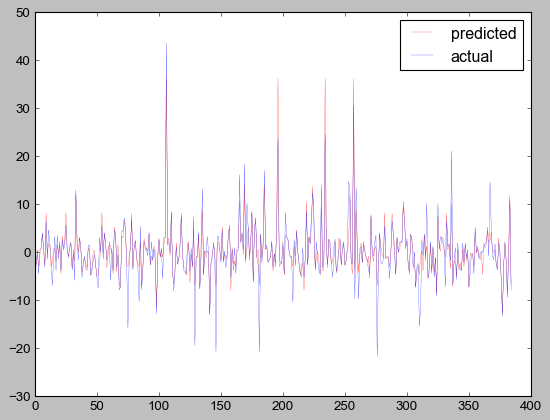

In [175]:
with plt.style.context('classic'):
    line1, =plt.plot(range(0,len(Y_predictions2)), Y_predictions2, 'r', linewidth = 0.2, label = 'predicted')
    line2, = plt.plot(range(0,len(Y_predictions2)), Y_test, linewidth = 0.2, label = 'actual')
    plt.legend(handles=[line1, line2])

It seems large positive shocks are accurately captured while negative shocks are not

## Important words

In [180]:
from os import path
from wordcloud import WordCloud
# Read the whole text.
text = " ".join(texts)





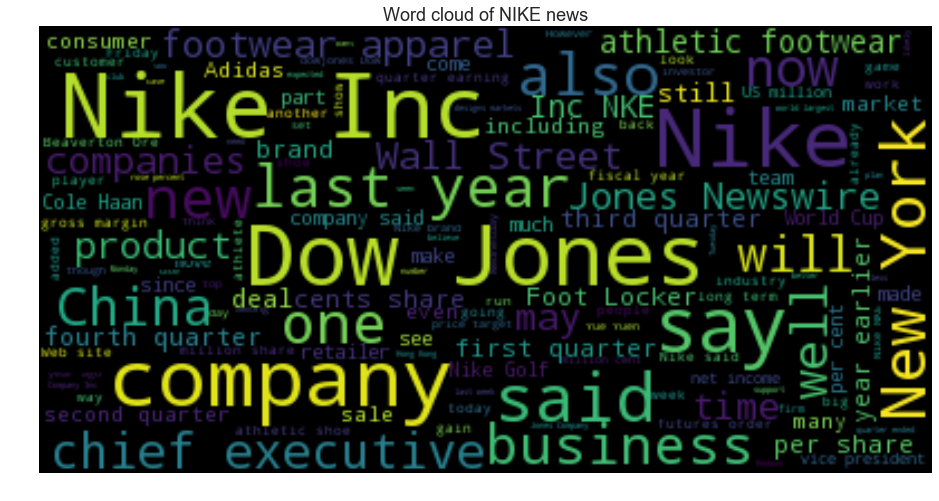

In [224]:
# Display the generated image:
# the matplotlib way:

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of NIKE news")
plt.show()

In [210]:
text_pos = ''
for i in range(0,100):
    if i != 3:
        text_pos += (' '+coefs_relevant['word'][i]) * int(math.floor(coefs_relevant['coefs'][i]*100))

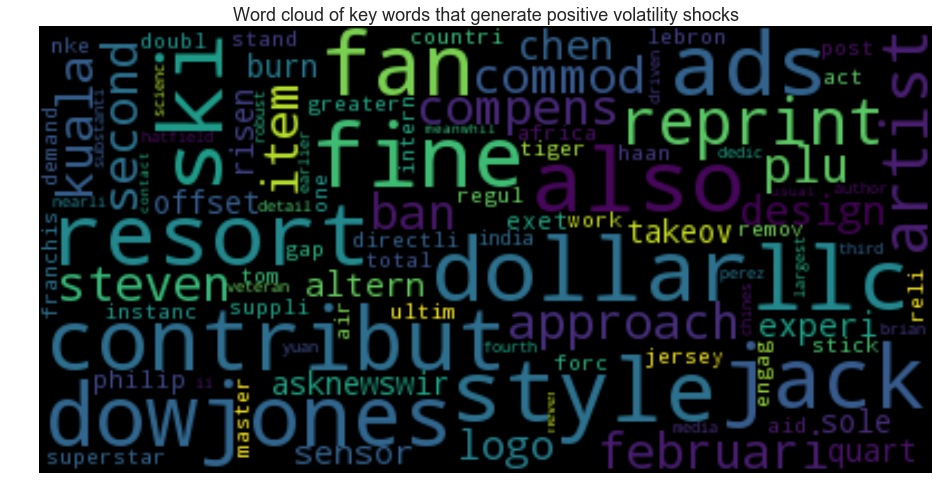

In [222]:
text_pos = ''
for i in range(0,100):
    if i != 3:
        text_pos += (' '+coefs_relevant['word'][i])
wordcloud = WordCloud(max_font_size=40).generate(text_pos)
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word cloud of key words that generate positive volatility shocks')
plt.show()

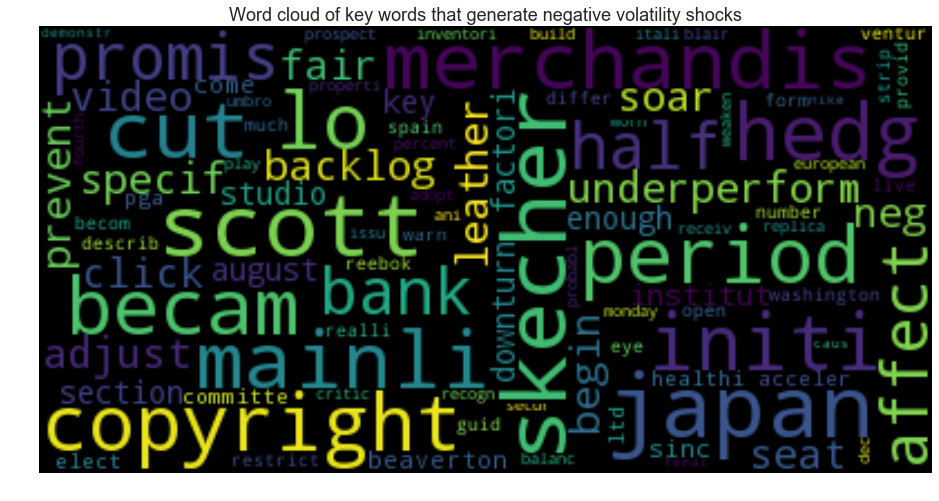

In [223]:
text_pos = ''
for i in range(len(coefs_relevant)-100,len(coefs_relevant)):
        text_pos += (' '+coefs_relevant['word'][i])
wordcloud = WordCloud(max_font_size=40).generate(text_pos)
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word cloud of key words that generate negative volatility shocks')
plt.show()

## Maps
We check which cities in the united states are the most frequently mentioned and are associated with the largest shocks.
Then we find out which countries are the most frequently mentioend.

In [234]:
index_date = {}
for i in range(0, len(news)):
    index_date[news['index'][i]] = news['date_t'][i]
date_shocks = {}
for i in range(0, len(shocks)):
    date_shocks[shocks['dates'][i]] = shocks['shocks'][i]
    

In [349]:
cities_shock = {}
for key in cities.keys():
    l = cities[key]
    count = 0
    shock = 0
    for i in range(len(l)):
        if index_date[i]:
            shock += date_shocks[index_date[i]]
            count +=1
        if count >=10:
            cities_shock[key] = (shock/count, count)
            

In [350]:
len(cities_shock)

263

In [351]:
cities_shock_US = {}
for key in cities_shock.keys():
    geo = GeoText(key)
    if geo.country_mentions.keys()[0] == 'US':
        cities_shock_US[key] = cities_shock[key]
len(cities_shock_US)

142

In [401]:
countries_shock = {}
for key in countries.keys():
    l = countries[key]
    count = 0
    shock = 0
    key_l = key.lower()
    for i in range(len(l)):
        if index_date[i]:
            shock += date_shocks[index_date[i]]
            count +=1
    if count >=1:
        if key_l in countries_shock:
            item = countries_shock[key_l]
            countries_shock[key_l] = ((item[0]*item[1]+shock)/(count+item[1]), count+item[1])
        else:
            countries_shock[key_l] = (shock/count, count)

In [396]:
cities_shock_US_np = np.array([(key, value[0], value[1]) for (key,value) in cities_shock_US.items() ])

In [397]:
cities_df = DataFrame(cities_shock_US_np,columns = ['City', 'shock', 'frequency'])
cities_df.to_csv('city_shocks2.csv')

In [402]:
countries_shock_np = np.array([(key, value[0], value[1]) for (key,value) in countries_shock.items() ])
countries_df = DataFrame(countries_shock_np,columns = ['Country', 'shock', 'frequency'])
countries_df.to_csv('country_shocks2.csv')

In [318]:
import plotly.plotly as py
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

,name,pop,lat,lon
0,New York,8287238,40.730599,-73.986581
1,Los Angeles,3826423,34.053717,-118.242727
2,Chicago,2705627,41.875555,-87.624421
3,Houston,2129784,29.758938,-95.367697
4,Philadelphia,1539313,39.952335,-75.163789


In [352]:
df2 = df;
df2['shock'] = None
df2['frequency'] = None
for i in range(len(df2)):
    city = df2['name'][i].strip()
    if  city in cities_shock_US.keys():
        #df2['shock'][i] = cities_shock_US[city][0]
        #df2['frequency'][i] = cities_shock_US[city][1]
        df2.loc[i,'shock'] = cities_shock_US[city][0]
        df2.loc[i,'frequency'] = cities_shock_US[city][1]


In [353]:
df2 = df2.loc[df2['frequency'].notnull(),:].reset_index(drop = True)
df2 = df2.sort_values(by = 'shock').reset_index(drop = True)
df2.tail()

,name,pop,lat,lon,shock,frequency
146,Chicago,2705627,41.875555,-87.624421,0.709658,207
147,New York,8287238,40.730599,-73.986581,0.804717,853
148,Converse,19072,43.020246,-105.504621,0.896324,1196
149,Beaverton,91406,45.487172,-122.803780,1.04153,929
150,Oregon,20330,43.979280,-120.737257,1.06759,1025


In [366]:


df2['text'] = df2['name'] + '<br>Frequency ' + (df2['frequency']).astype(str)+' times'
limits = [(0,30),(30, 60),(60, 90),(90, 120),(120, 150)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","rgb(0,133,27)"]
cities_plot = []
scale = 0.5

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df2[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['frequency']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{:f} - {:f}'.format(df2['shock'][lim[0]],df2['shock'][lim[1]]) )
    cities_plot.append(city)

layout = dict(
        title = 'Cities mentioned in news about NIKE from April 10th, 2001 to December 31st, 2014',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities_plot, layout=layout )
py.iplot( fig, validate=False, filename='NIKE-bubble-map-shocks' )

The size of the bubble is proportional to the number of times the city is mentioned in the news. The color is determined by the average shock on the day when the city is mentioned. 
We only include cities that have been mentioned no fewer than ten times.
The plot shows that the cities mentioned most tend to be mentioned on the day when shocks are higher.

In [372]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
df.tail()

,COUNTRY,GDP (BILLIONS),CODE
217,Virgin Islands,5.08,VGB
218,West Bank,6.64,WBG
219,Yemen,45.45,YEM
220,Zambia,25.61,ZMB
221,Zimbabwe,13.74,ZWE


In [403]:

countries_shock_small = countries_shock
#for key in countries_shock.keys():
#    countries_shock_small[key.lower()] = countries_shock[key]

In [423]:
df2 = df;
df2['shock'] = None
df2['frequency'] = None
item = countries_shock_small['china']
countries_shock_small['china'] = (item[0], item[1]/4)
for i in range(len(df2)):
    country_lower = df2['COUNTRY'][i].strip().lower()
    if  country_lower in countries_shock_small.keys():
        #df2['shock'][i] = cities_shock_US[city][0]
        #df2['frequency'][i] = cities_shock_US[city][1]
        df2.loc[i,'shock'] = countries_shock_small[country_lower][0]
        df2.loc[i,'frequency'] = countries_shock_small[country_lower][1]
#df2 = df2.loc[df2['frequency'].notnull(),:].reset_index(drop = True)
#df2 = df2.sort_values(by = 'frequency').reset_index(drop = True)

#df2.loc[len(df2)-1,'frequency'] = df2.loc[len(df2)-1,'frequency']/4
df2.tail()

,COUNTRY,GDP (BILLIONS),CODE,shock,frequency
217,Virgin Islands,5.08,VGB,None,None
218,West Bank,6.64,WBG,None,None
219,Yemen,45.45,YEM,None,None
220,Zambia,25.61,ZMB,-8.27311,3
221,Zimbabwe,13.74,ZWE,-5.28131,4


In [430]:
import numpy as np


data = [ dict(
        type = 'choropleth',
        locations = df2['CODE'],
        z = df2['frequency'],
        text = df2['COUNTRY'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = True,
            tickprefix = '',
            title = 'Countries mentioned in news about NIKE from April 10th, 2001 to December 31st, 2014'),
      ) ]

layout = dict(
    title = 'Number of times mentioned in news about NIKE from April 10th, 2001 to December 31st, 2014',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='NIKE-bubble-world-frequency' )

The BRIC countries are quite frequently mentioned. The economy involvement of the Africa continent is still low.